In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

warnings.filterwarnings('ignore')

# Incompressible Stokes equation on topological cylinder

Initial time = 10


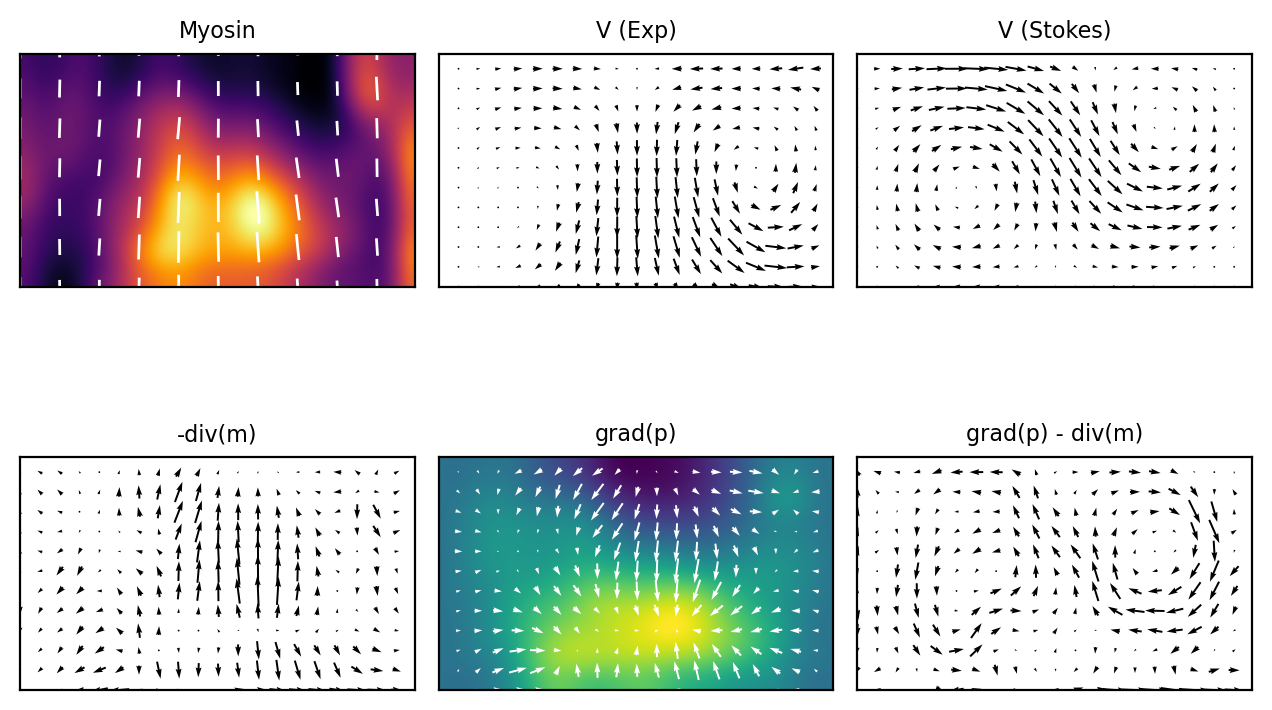

In [2]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from morphogenesis.decomposition.decomposition_model import LeftRightSymmetrize
from morphogenesis.forecasting.transforms import *
from morphogenesis.plot_utils import *

from skimage.transform import downscale_local_mean
from scipy import sparse

class FlowSolver(object):
    def __init__(self, nDV=236, nAP=200, sigma=3, mu=1):
        super(FlowSolver, self).__init__()        
        
        self.nDV = nDV
        self.nAP = nAP
        self.sigma = sigma
        self.mu = mu
        
        self.dAP = (ap_max - ap_min) / (nAP -1)
        self.dDV = (dv_max - dv_min) / (nDV -1)
        self.sigma = sigma
                
        #Build poisson matrix
        I_x = sparse.eye(self.nAP)
        I_y = sparse.eye(self.nDV)
        
        D_xx = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(self.nAP, self.nAP))
        D_yy = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(self.nDV, self.nDV))
        
        #Dirichlet BCs in AP direction
        D_xx = sparse.lil_matrix(D_xx)
        D_xx[0, [0, 1]] = [1, 0]
        D_xx[-1, [-2, -1]] = [0, 1]
        D_xx = sparse.csr_matrix(D_xx)
        
        #periodic BCs in DV direction
        D_yy = sparse.lil_matrix(D_yy)
        D_yy[0, [-1, 0, 1]] = [1, -2, 1]
        D_yy[-1, [-2, -1, 0]] = [1, -2, 1]
        D_yy = sparse.csr_matrix(D_yy)
        
        D_xx = sparse.kron(I_y, D_xx) / self.dAP**2
        D_yy = sparse.kron(D_yy, I_x) / self.dDV**2
        
        self.A = D_xx + D_yy
        self.mu = mu
        
        self.gradient = EmbryoGradient(sigma=self.sigma)
                
    def boundary_AP(self, f, ap=10):
        f[..., :ap] = 0
        f[..., -ap:] = 0
        return f
        
    def get_velocity(self, t, y):
        #Fit the gradient operator
        self.gradient.fit(y)
        
        #Get myosin and source
        m = y.reshape([2, 2, self.nDV, self.nAP])

        #Gradients
        div_m = np.einsum('ijyxj->iyx',self.gradient(m))
        d2_m = np.einsum('iyxi->yx', self.gradient(div_m))
                
        p = sparse.linalg.spsolve(self.A, d2_m.flatten())
        
        p = p.reshape([self.nDV, self.nAP])
        d1_p = self.gradient(p).transpose(2, 0, 1)
        
        rhs = -div_m + d1_p
        rhs /= self.mu
        
        v_y = sparse.linalg.spsolve(self.A, rhs[0].flatten())
        v_x = sparse.linalg.spsolve(self.A, rhs[1].flatten())
        
        v = np.stack([v_y, v_x]).reshape([2, self.nDV, self.nAP])
                        
        return v, p, div_m

folder = '../flydrive/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble'
tt = 20
t0 = np.load(f'{folder}/t.npy')
print(f'Initial time = {t0[tt]}')
m0 = np.load(f'{folder}/tensor2D.npy', mmap_mode='r')[tt]
v0 = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')[tt]


m0 = LeftRightSymmetrize().fit_transform(m0.reshape([1, 4, 236, 200]))

model = FlowSolver(mu=1)
v, p, div_m = model.get_velocity(0, m0)

fig, ax = plt.subplots(2, 3, dpi=200)
plot_tensor(ax[0, 0], m0)
plot_vector(ax[0, 1], v0)
plot_vector(ax[1, 0], -div_m)
plot_scalar(ax[1, 1], p)
plot_vector(ax[0, 2], v)
plot_vector(ax[1, 1], model.gradient(p).transpose([2, 0, 1]), color='white')
plot_vector(ax[1, 2], model.gradient(p).transpose([2, 0, 1]) - div_m)

ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('V (Exp)')
ax[0, 2].set_title('V (Stokes)')

ax[1, 0].set_title('-div(m)')
ax[1, 1].set_title('grad(p)')
ax[1, 2].set_title('grad(p) - div(m)')

plt.tight_layout()

Initial time = 10


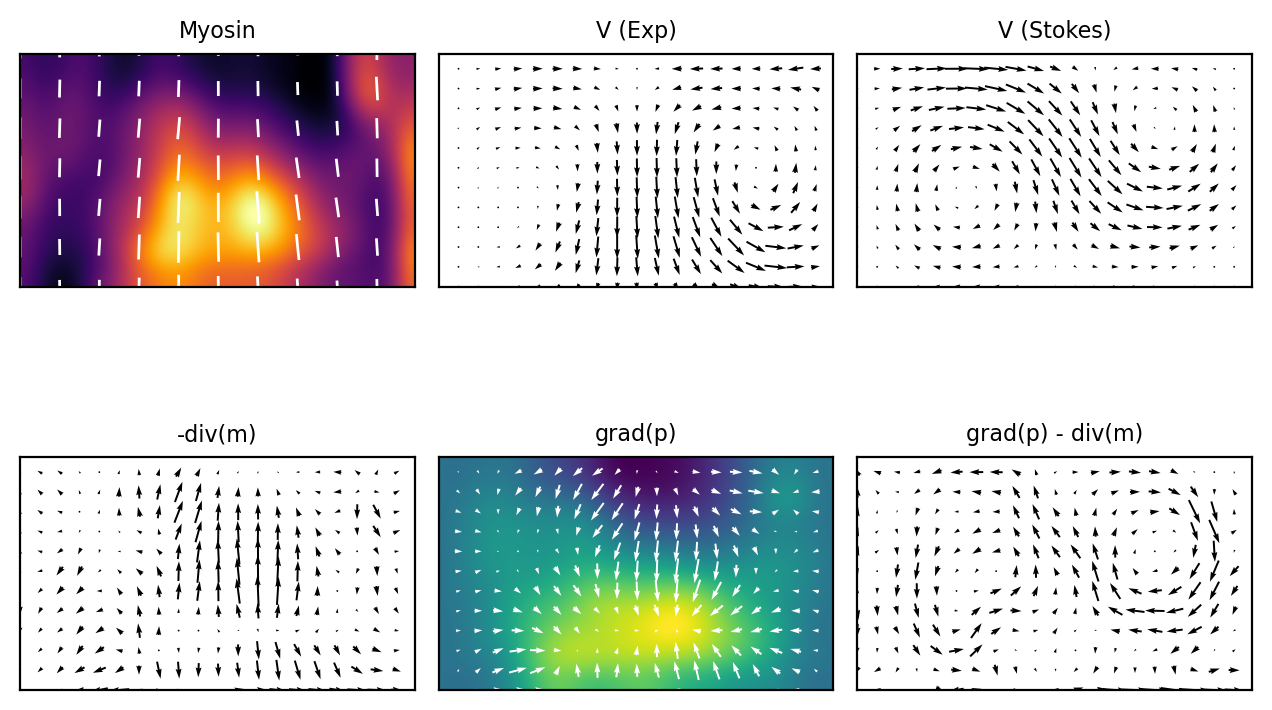

In [3]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from morphogenesis.decomposition.decomposition_model import LeftRightSymmetrize
from morphogenesis.forecasting.transforms import *
from morphogenesis.plot_utils import *

from skimage.transform import downscale_local_mean
from scipy import sparse

class FlowSolver(object):
    def __init__(self, nDV=236, nAP=200, sigma=3, mu=1):
        super(FlowSolver, self).__init__()        
        
        self.nDV = nDV
        self.nAP = nAP
        self.sigma = sigma
        self.mu = mu
        
        self.dAP = (ap_max - ap_min) / (nAP -1)
        self.dDV = (dv_max - dv_min) / (nDV -1)
        self.sigma = sigma
                
        #Build poisson matrix
        I_x = sparse.eye(self.nAP)
        I_y = sparse.eye(self.nDV)
        
        D_xx = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(self.nAP, self.nAP))
        D_yy = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(self.nDV, self.nDV))
        
        #Dirichlet BCs in AP direction
        D_xx = sparse.lil_matrix(D_xx)
        D_xx[0, [0, 1]] = [1, 0]
        D_xx[-1, [-2, -1]] = [0, 1]
        D_xx = sparse.csr_matrix(D_xx)
        
        #periodic BCs in DV direction
        D_yy = sparse.lil_matrix(D_yy)
        D_yy[0, [-1, 0, 1]] = [1, -2, 1]
        D_yy[-1, [-2, -1, 0]] = [1, -2, 1]
        D_yy = sparse.csr_matrix(D_yy)
        
        D_xx = sparse.kron(I_y, D_xx) / self.dAP**2
        D_yy = sparse.kron(D_yy, I_x) / self.dDV**2
        
        self.A = D_xx + D_yy
        self.B = sparse.kron(sparse.eye(2), self.A)
        self.mu = mu
        
        self.gradient = EmbryoGradient(sigma=self.sigma)
                
    def boundary_AP(self, f, ap=10):
        f[..., :ap] = 0
        f[..., -ap:] = 0
        return f
        
    def get_velocity(self, t, y):
        #Fit the gradient operator
        self.gradient.fit(y)
        
        #Get myosin and source
        m = y.reshape([2, 2, self.nDV, self.nAP])

        #Gradients
        div_m = np.einsum('ijyxj->iyx',self.gradient(m))
        d2_m = np.einsum('iyxi->yx', self.gradient(div_m))
                
        p = sparse.linalg.spsolve(self.A, d2_m.flatten())
        
        p = p.reshape([self.nDV, self.nAP])
        d1_p = self.gradient(p).transpose(2, 0, 1)
        
        rhs = -div_m + d1_p
        rhs /= self.mu
        
        v = sparse.linalg.spsolve(self.B, rhs.flatten())
        v = v.reshape([2, self.nDV, self.nAP])
                        
        return v, p, div_m

folder = '../flydrive/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble'
tt = 20
t0 = np.load(f'{folder}/t.npy')
print(f'Initial time = {t0[tt]}')
m0 = np.load(f'{folder}/tensor2D.npy', mmap_mode='r')[tt]
v0 = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')[tt]


m0 = LeftRightSymmetrize().fit_transform(m0.reshape([1, 4, 236, 200]))

model = FlowSolver(mu=1)
v, p, div_m = model.get_velocity(0, m0)

fig, ax = plt.subplots(2, 3, dpi=200)
plot_tensor(ax[0, 0], m0)
plot_vector(ax[0, 1], v0)
plot_vector(ax[1, 0], -div_m)
plot_scalar(ax[1, 1], p)
plot_vector(ax[0, 2], v)
plot_vector(ax[1, 1], model.gradient(p).transpose([2, 0, 1]), color='white')
plot_vector(ax[1, 2], model.gradient(p).transpose([2, 0, 1]) - div_m)

ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('V (Exp)')
ax[0, 2].set_title('V (Stokes)')

ax[1, 0].set_title('-div(m)')
ax[1, 1].set_title('grad(p)')
ax[1, 2].set_title('grad(p) - div(m)')

plt.tight_layout()

Initial time = 10
5.2754237288135596e-05


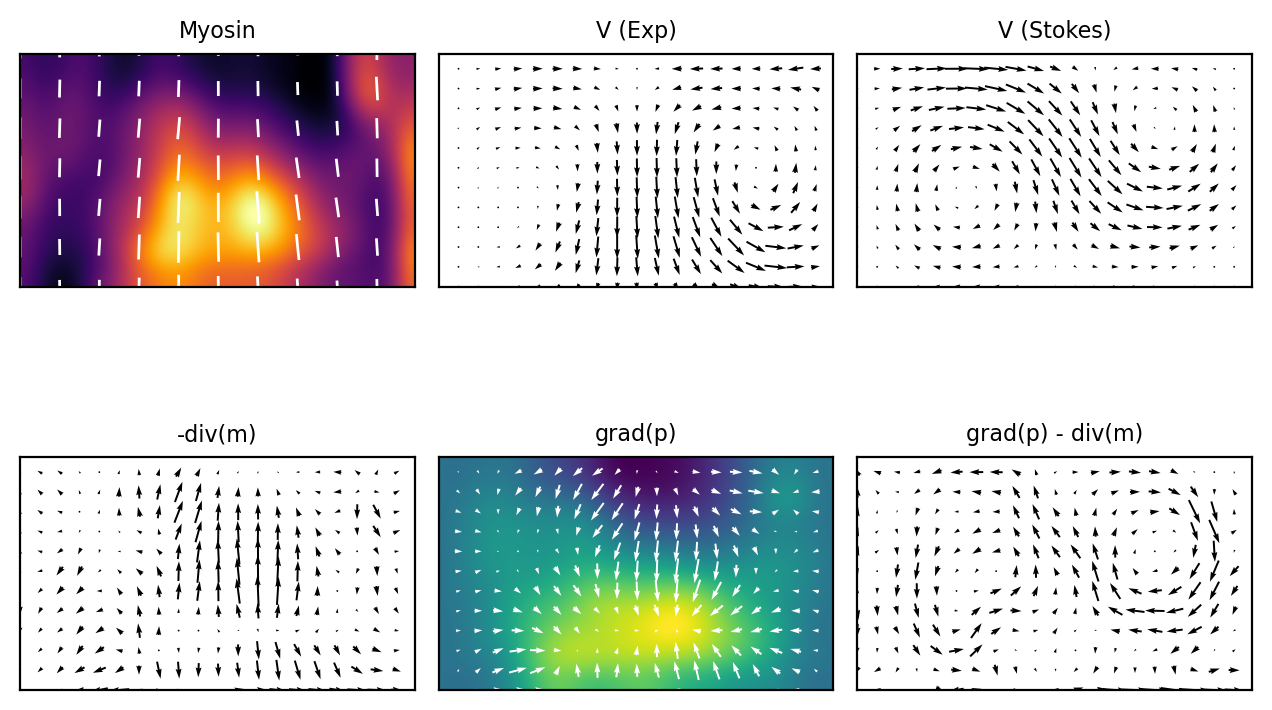

In [7]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d
import scipy
from morphogenesis.decomposition.decomposition_model import LeftRightSymmetrize
from morphogenesis.forecasting.transforms import *
from morphogenesis.plot_utils import *

from skimage.transform import downscale_local_mean
from scipy import sparse

class FlowSolver(object):
    def __init__(self, nDV=236, nAP=200, sigma=3, mu=1):
        super(FlowSolver, self).__init__()        
        
        self.nDV = nDV
        self.nAP = nAP
        self.sigma = sigma
        self.mu = mu
        
        self.dAP = (ap_max - ap_min) / (nAP -1)
        self.dDV = (dv_max - dv_min) / (nDV -1)
        self.sigma = sigma
                
        #Build poisson matrix
        I_x = sparse.eye(self.nAP)
        I_y = sparse.eye(self.nDV)
        
        D_xx = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(self.nAP, self.nAP))
        D_yy = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(self.nDV, self.nDV))
        
        #Dirichlet BCs in AP direction
        D_xx = sparse.lil_matrix(D_xx)
        D_xx[0, [0, 1]] = [1, 0]
        D_xx[-1, [-2, -1]] = [0, 1]
        D_xx = sparse.csr_matrix(D_xx)
        
        #periodic BCs in DV direction
        D_yy = sparse.lil_matrix(D_yy)
        D_yy[0, [-1, 0, 1]] = [1, -2, 1]
        D_yy[-1, [-2, -1, 0]] = [1, -2, 1]
        D_yy = sparse.csr_matrix(D_yy)
        
        D_xx = sparse.kron(I_y, D_xx) / self.dAP**2
        D_yy = sparse.kron(D_yy, I_x) / self.dDV**2
        
        self.A = D_xx + D_yy
        self.B = sparse.kron(sparse.eye(2), self.A)
        print(self.B.getnnz() / np.prod(self.B.shape))
        self.mu = mu
        
        self.gradient = EmbryoGradient(sigma=self.sigma)
                
    def boundary_AP(self, f, ap=10):
        f[..., :ap] = 0
        f[..., -ap:] = 0
        return f
        
    def get_velocity(self, t, y):
        #Fit the gradient operator
        self.gradient.fit(y)
        
        #Get myosin and source
        m = y.reshape([2, 2, self.nDV, self.nAP])

        #Gradients
        div_m = np.einsum('ijyxj->iyx',self.gradient(m))
        d2_m = np.einsum('iyxi->yx', self.gradient(div_m))
                
        p = sparse.linalg.spsolve(self.A, d2_m.flatten())
        
        p = p.reshape([self.nDV, self.nAP])
        d1_p = self.gradient(p).transpose(2, 0, 1)
        
        rhs = -div_m + d1_p
        rhs /= self.mu
        
        v = sparse.linalg.spsolve(self.B, rhs.flatten())
        v = v.reshape([2, self.nDV, self.nAP])
                        
        return v, p, div_m

folder = '../flydrive/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble'
tt = 20
t0 = np.load(f'{folder}/t.npy')
print(f'Initial time = {t0[tt]}')
m0 = np.load(f'{folder}/tensor2D.npy', mmap_mode='r')[tt]
v0 = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')[tt]


m0 = LeftRightSymmetrize().fit_transform(m0.reshape([1, 4, 236, 200]))

model = FlowSolver(mu=1)
v, p, div_m = model.get_velocity(0, m0)

fig, ax = plt.subplots(2, 3, dpi=200)
plot_tensor(ax[0, 0], m0)
plot_vector(ax[0, 1], v0)
plot_vector(ax[1, 0], -div_m)
plot_scalar(ax[1, 1], p)
plot_vector(ax[0, 2], v)
plot_vector(ax[1, 1], model.gradient(p).transpose([2, 0, 1]), color='white')
plot_vector(ax[1, 2], model.gradient(p).transpose([2, 0, 1]) - div_m)

ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('V (Exp)')
ax[0, 2].set_title('V (Stokes)')

ax[1, 0].set_title('-div(m)')
ax[1, 1].set_title('grad(p)')
ax[1, 2].set_title('grad(p) - div(m)')

plt.tight_layout()

# Compressible Stokes on a topological cylinder

Initial time = 10
9.491525423728813e-05


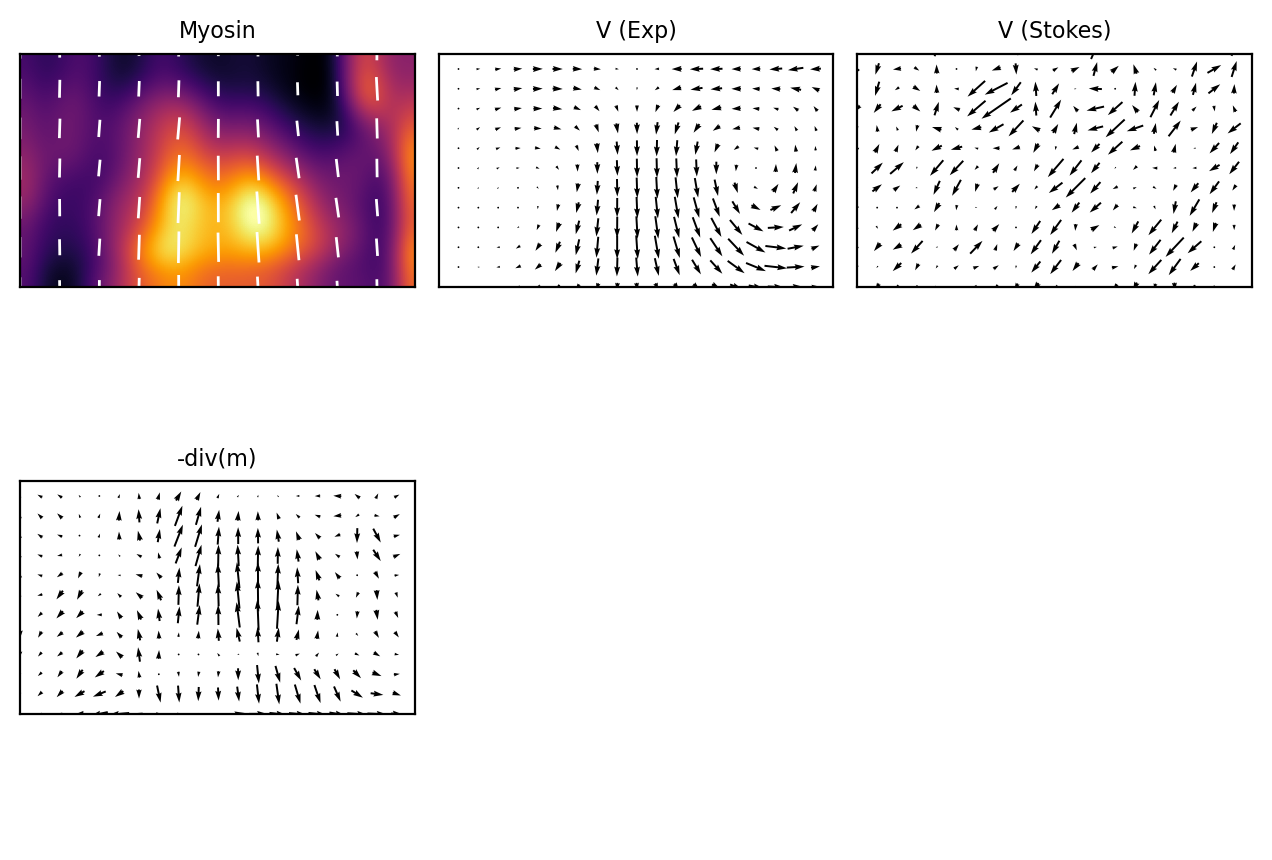

In [11]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from morphogenesis.decomposition.decomposition_model import LeftRightSymmetrize
from morphogenesis.forecasting.transforms import *
from morphogenesis.plot_utils import *

from skimage.transform import downscale_local_mean
from scipy import sparse

class FlowSolver(object):
    def __init__(self, nDV=236, nAP=200, sigma=3, mu=1, B=100):
        super(FlowSolver, self).__init__()        
        
        self.nDV = nDV
        self.nAP = nAP
        self.sigma = sigma
        self.mu = mu
        self.B = B
        
        self.dAP = (ap_max - ap_min) / (nAP -1)
        self.dDV = (dv_max - dv_min) / (nDV -1)
        self.sigma = sigma
                
        #Build poisson matrix
        I_x = sparse.eye(self.nAP)
        I_y = sparse.eye(self.nDV)
        
        D_x = sparse.diags([-0.5, 0, 0.5], [-1, 0, 1], shape=(self.nAP, self.nAP))
        D_y = sparse.diags([-0.5, 0, 0.5], [-1, 0, 1], shape=(self.nDV, self.nDV))

        D_xx = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(self.nAP, self.nAP))
        D_yy = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(self.nDV, self.nDV))
        
        #Dirichlet BCs in AP direction
        D_xx = sparse.lil_matrix(D_xx)
        D_xx[0, [0, 1]] = [1, 0]
        D_xx[-1, [-2, -1]] = [0, 1]
        D_xx = sparse.csr_matrix(D_xx)

        D_x = sparse.lil_matrix(D_x)
        D_x[0, [0, 1]] = [1, 0]
        D_x[-1, [-2, -1]] = [0, 1]
        D_x = sparse.csr_matrix(D_x)
        
        #Periodic BCs in DV direction
        D_yy = sparse.lil_matrix(D_yy)
        D_yy[0, [-1, 0, 1]] = [1, -2, 1]
        D_yy[-1, [-2, -1, 0]] = [1, -2, 1]
        D_yy = sparse.csr_matrix(D_yy)

        D_y = sparse.lil_matrix(D_y)
        D_y[0, [-1, 0, 1]] = [-0.5, 0, 0.5]
        D_y[-1, [-2, -1, 0]] = [-0.5, 0, 0.5]
        D_y = sparse.csr_matrix(D_y)

        D_xx = sparse.kron(I_y, D_xx) / self.dAP**2
        D_yy = sparse.kron(D_yy, I_x) / self.dDV**2
        D_xy = sparse.kron(D_x, D_y) / self.dAP / self.dDV
        
        self.A1  = sparse.kron(sparse.eye(2), D_xx + D_yy)
        self.A2  = sparse.kron(np.array([[0, 1], [1, 0]]), D_xy)
        self.A2 += sparse.kron(np.array([[1, 0], [0, 0]]), D_yy)
        self.A2 += sparse.kron(np.array([[0, 0], [0, 1]]), D_xx)

        self.A = self.A1 + B * self.A2
        print(self.A.getnnz() / np.prod(self.A.shape))

        self.B = B
        self.mu = mu
        
        self.gradient = EmbryoGradient(sigma=self.sigma)
                
    def boundary_AP(self, f, ap=10):
        f[..., :ap] = 0
        f[..., -ap:] = 0
        return f
        
    def get_velocity(self, t, y):
        #Fit the gradient operator
        self.gradient.fit(y)
        
        #Get myosin and source
        m = y.reshape([2, 2, self.nDV, self.nAP])

        #Gradients
        div_m = np.einsum('ijyxj->iyx',self.gradient(m))
        rhs = -div_m / self.mu
        
        v = sparse.linalg.spsolve(self.A, rhs.flatten())
        v = v.reshape([2, self.nDV, self.nAP])
                        
        return v

folder = '../flydrive/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble'
tt = 20
t0 = np.load(f'{folder}/t.npy')
print(f'Initial time = {t0[tt]}')
m0 = np.load(f'{folder}/tensor2D.npy', mmap_mode='r')[tt]
v0 = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')[tt]


m0 = LeftRightSymmetrize().fit_transform(m0.reshape([1, 4, 236, 200]))

model = FlowSolver(mu=1, B=1)
v = model.get_velocity(0, m0)

fig, ax = plt.subplots(2, 3, dpi=200)
plot_tensor(ax[0, 0], m0)
plot_vector(ax[0, 1], v0)
plot_vector(ax[1, 0], -div_m)
plot_vector(ax[0, 2], v)

ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('V (Exp)')
ax[0, 2].set_title('V (Stokes)')

ax[1, 0].set_title('-div(m)')
ax[1, 1].axis('off')
ax[1, 2].axis('off')

plt.tight_layout()
